In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import matplotlib.cm as cm
import sys
sys.path.insert(0, '../')
from dataloaders.visual_genome import VGDataLoader, VG
from dataloaders.visual_genome200 import VG200
from dataloaders.visual_genome200 import VGDataLoader as VGDataLoader200
from dataloaders.visual_genome200_keyrel import VG200_Keyrel
from dataloaders.visual_genome200_keyrel import VGDataLoader as VGDataLoader200_KR
from dataloaders.visual_genome200_keyrel_captions import VG200_Keyrel_captions
from dataloaders.visual_genome200_keyrel_captions import VGDataLoader as VGDataLoader200_KR_captions
import numpy as np
import torch
from lib.pytorch_misc import optimistic_restore
from lib.evaluation.sg_eval import BasicSceneGraphEvaluator
from tqdm import tqdm
from config import BOX_SCALE, IM_SCALE
import dill as pkl
import os
from torchvision import transforms


/home/wangwenbin/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
VGdata = VG200_Keyrel_captions
VGLoader = VGDataLoader200_KR_captions
train, val, test = VGdata.splits(num_val_im=5000, filter_duplicate_rels=True,
                                 use_proposals=False,
                                 filter_non_overlap=False)
train_loader, val_loader = VGLoader.splits(train, test, mode='rel',
                                           batch_size=1,
                                           num_workers=0,
                                           num_gpus=1)
ind_to_classes, ind_to_predicates = train.ind_to_classes, train.ind_to_predicates


vocab size is  5641
DataLoader loading h5 file
max sequence length in data is  16
vocab size is  5641
DataLoader loading h5 file
max sequence length in data is  16
vocab size is  5641
DataLoader loading h5 file
max sequence length in data is  16


In [85]:
vg200train, _, vg200test = VG200.splits(num_val_im=-1, filter_duplicate_rels=True,
                                 use_proposals=False,
                                 filter_non_overlap=False)
vg200krtrain, _, vg200krtest = VG200_Keyrel.splits(num_val_im=-1, filter_duplicate_rels=True,
                                 use_proposals=False,
                                 filter_non_overlap=False)
print(len(vg200train), len(vg200test), len(vg200krtrain), len(vg200krtest))

32510 14052 18720 8272


In [104]:
# 1) statistics num. of key rels - image distribution 
# 2) statistics: for each predicate, the distribution of whether to be key rel or not
from collections import defaultdict
keyrel_imgs_distribution = defaultdict(int)
rel_keyornot_distribution = np.zeros((len(ind_to_predicates)-1, 2))
for ds in [vg200krtrain, vg200krtest]:
    for i, item in enumerate(ds):
        if i % 3000 == 0:
            print(i)
        #if i>500:
        #    break
        keyrel_imgs_distribution[item['key_rels'].shape[0]] += 1
        gt_rels = item['gt_relations']
        key_rels_idxes = item['key_rels']
        for idx, rel in enumerate(gt_rels):
            rel_keyornot_distribution[rel[2]-1, 0] += 1
            if idx in key_rels_idxes:
                rel_keyornot_distribution[rel[2]-1, 1] += 1
P = []
for k in sorted(list(keyrel_imgs_distribution.keys())):
    P.append([k, keyrel_imgs_distribution[k]])
P = np.array(P, dtype=np.float64)
P[:, 1] = P[:, 1] / np.sum(P[:, 1])
print(P)

# column 0: is key; column: not key
rel_keyornot_distribution[:, 0] = rel_keyornot_distribution[:, 1] / rel_keyornot_distribution[:, 0]
rel_keyornot_distribution[:, 1] = 1 - rel_keyornot_distribution[:, 0]
# sort:
index = np.argsort(rel_keyornot_distribution[:, 0] * -1)
rel_keyornot_distribution = rel_keyornot_distribution[index]
sort_x_name = [ind_to_predicates[1:][i] for i in index]
print(rel_keyornot_distribution)
print(sort_x_name)


0
3000
6000
9000
12000
15000
18000
0
3000
6000
[[1.000e+00 3.679e-01]
 [2.000e+00 2.274e-01]
 [3.000e+00 1.379e-01]
 [4.000e+00 9.203e-02]
 [5.000e+00 5.698e-02]
 [6.000e+00 3.683e-02]
 [7.000e+00 2.575e-02]
 [8.000e+00 1.567e-02]
 [9.000e+00 1.086e-02]
 [1.000e+01 7.558e-03]
 [1.100e+01 4.705e-03]
 [1.200e+01 4.372e-03]
 [1.300e+01 2.556e-03]
 [1.400e+01 1.926e-03]
 [1.500e+01 1.667e-03]
 [1.600e+01 8.521e-04]
 [1.700e+01 8.892e-04]
 [1.800e+01 8.151e-04]
 [1.900e+01 4.446e-04]
 [2.000e+01 5.928e-04]
 [2.100e+01 3.334e-04]
 [2.200e+01 2.964e-04]
 [2.300e+01 1.852e-04]
 [2.400e+01 1.482e-04]
 [2.500e+01 1.111e-04]
 [2.600e+01 1.482e-04]
 [2.700e+01 1.111e-04]
 [2.800e+01 2.223e-04]
 [2.900e+01 1.111e-04]
 [3.000e+01 3.705e-05]
 [3.100e+01 7.410e-05]
 [3.300e+01 3.705e-05]
 [3.400e+01 7.410e-05]
 [3.500e+01 3.705e-05]
 [3.600e+01 1.111e-04]
 [4.000e+01 3.705e-05]
 [4.100e+01 3.705e-05]
 [4.200e+01 3.705e-05]
 [4.600e+01 3.705e-05]
 [5.200e+01 3.705e-05]
 [5.900e+01 3.705e-05]
 [7.000e+0

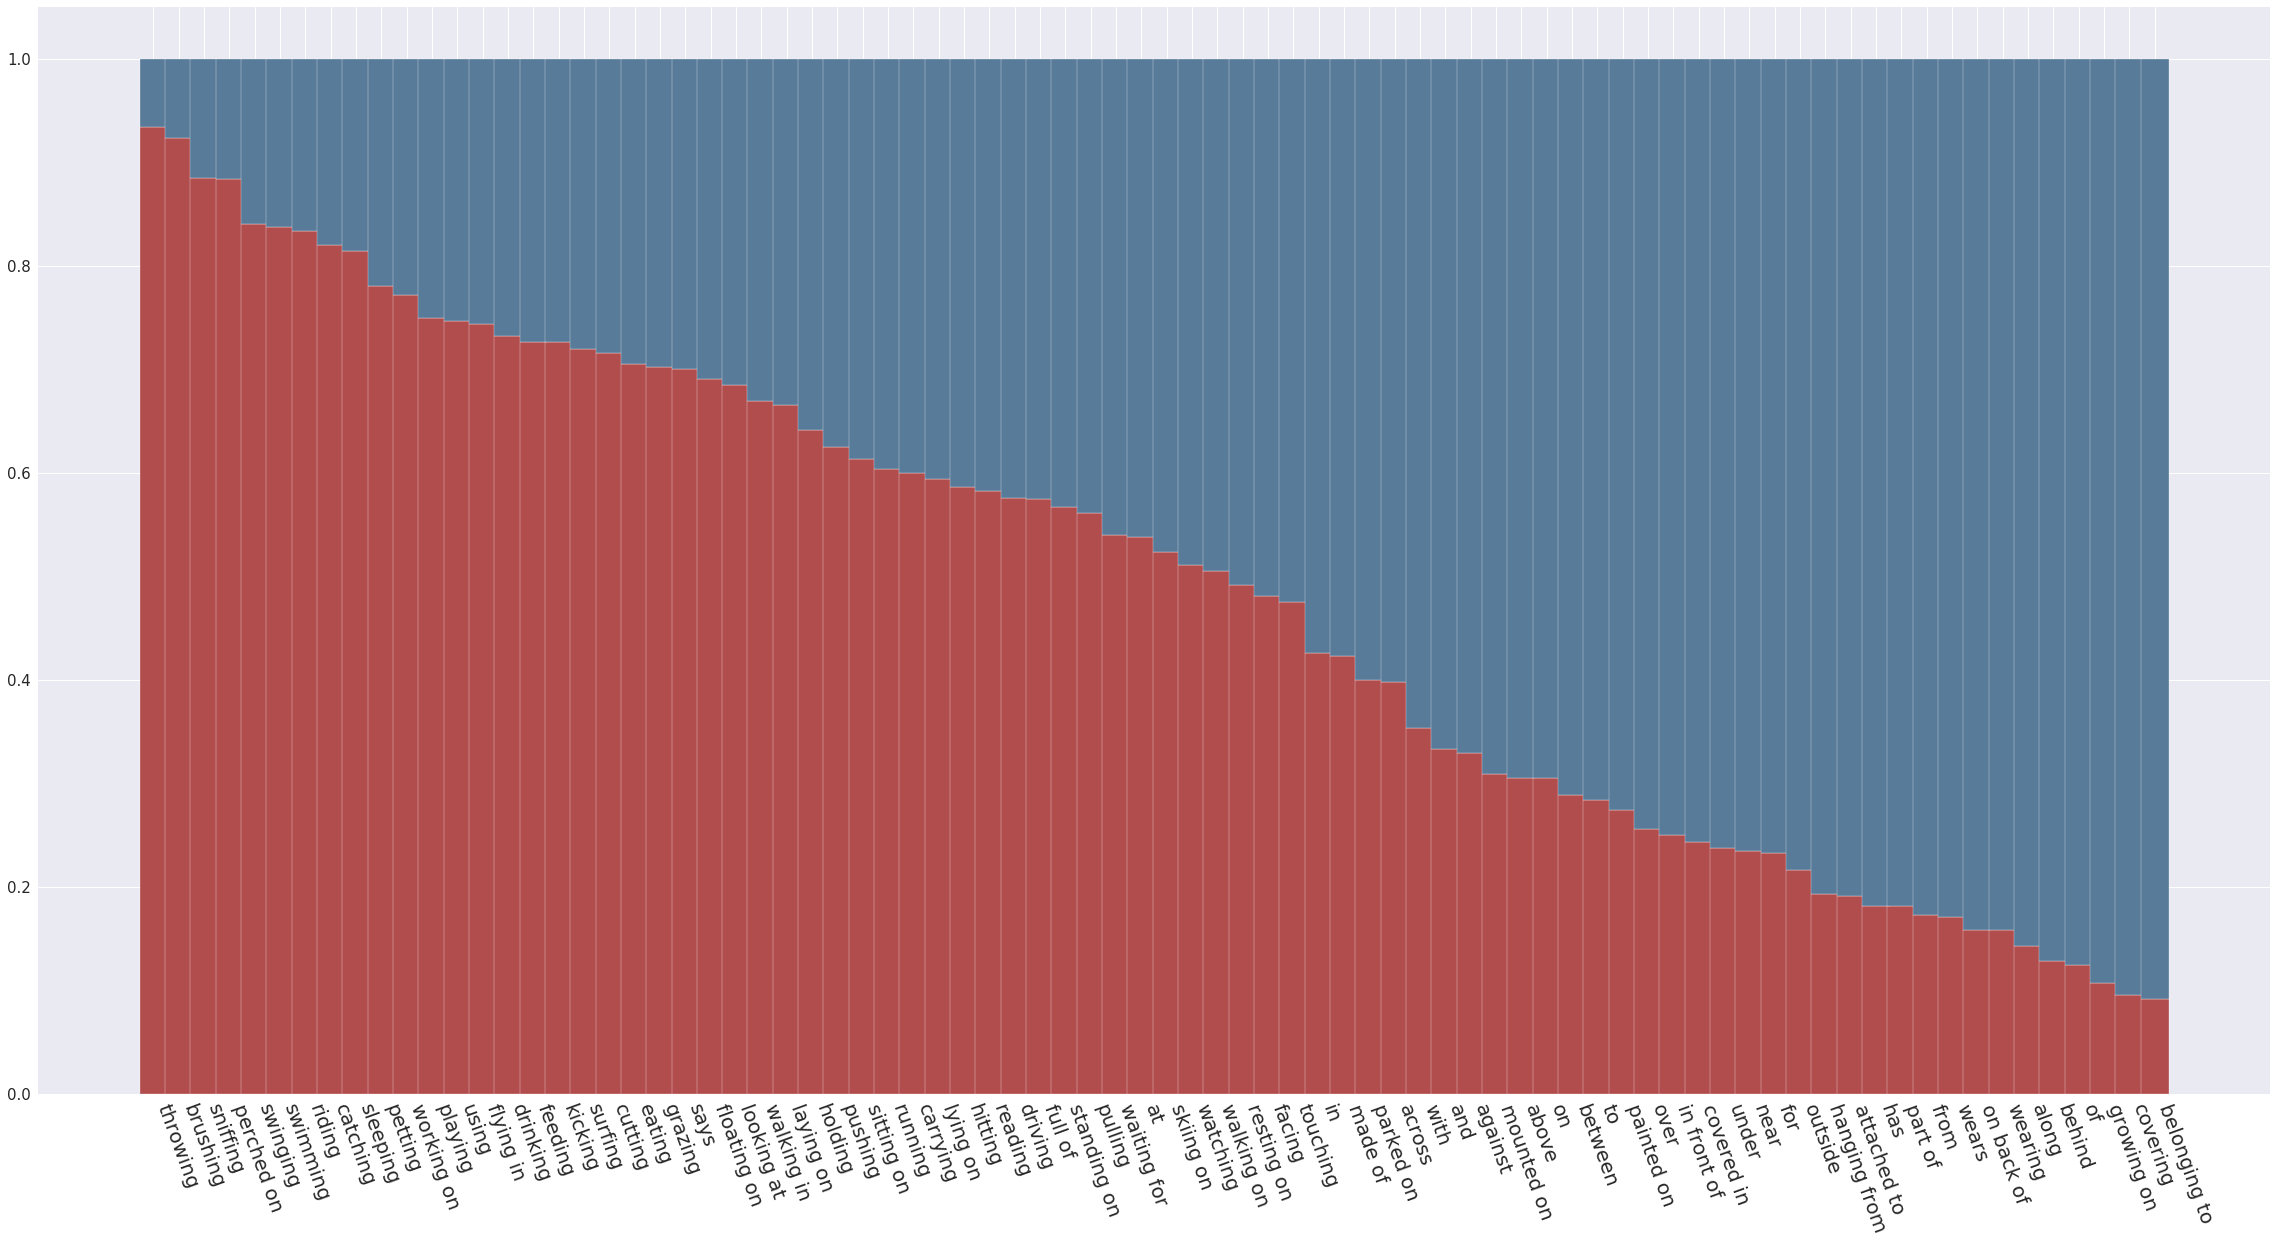

In [121]:
from matplotlib import rc
import seaborn as sns
num = 2
barWidth = 1.1
plt.figure(figsize=(40,20))
sns.set(palette=sns.color_palette("Set1", 2, desat=0.5), color_codes=False)

num_col = len(sort_x_name)
r = list(range(len(sort_x_name)))
cumulate = [0 for k in sort_x_name]
for i in range(num):
    column = rel_keyornot_distribution[:, i].tolist()
    plt.bar(r, column, bottom=cumulate, edgecolor='white', width=barWidth)
    cumulate = [column[j] + cumulate[j] for j in range(len(column))]
# sns.palplot(sns.color_palette("cubehelix", 8))
plt.xticks(r, sort_x_name, rotation=-70, fontsize=20, ha='left')
# plt.xlabel("group")
plt.yticks(fontsize=15)
# Show graphic
plt.savefig('supp_figure2.pdf', bbox_inches='tight', pad_inches=0.0)
plt.show()

In [89]:
# statistics sample num in VG200kr
obj_num = 0
rel_num = 0
vgkr_train_loader, vgkr_val_loader = VGDataLoader200_KR.splits(vg200krtrain, vg200krtest, mode='rel',
                                                   batch_size=256,
                                                   num_workers=0,
                                                   num_gpus=1)
for b, batch in enumerate(vgkr_train_loader):
    print(b)
    gt_boxes = batch[0][3].data.numpy()
    rels = batch[0][5].data.numpy()
    obj_num += gt_boxes.shape[0]
    rel_num += rels.shape[0]
for b, batch in enumerate(vgkr_val_loader):
    print(b)
    gt_boxes = batch[0][3].data.numpy()
    rels = batch[0][5].data.numpy()
    obj_num += gt_boxes.shape[0]
    rel_num += rels.shape[0]
print(obj_num, rel_num)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
2

1819
1820
1821
1822
1823
1824
1825
1826
1827
1828
1829
1830
1831
1832
1833
1834
1835
1836
1837
1838
1839
1840
1841
1842
1843
1844
1845
1846
1847
1848
1849
1850
1851
1852
1853
1854
1855
1856
1857
1858
1859
1860
1861
1862
1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018


3459
3460
3461
3462
3463
3464
3465
3466
3467
3468
3469
3470
3471
3472
3473
3474
3475
3476
3477
3478
3479
3480
3481
3482
3483
3484
3485
3486
3487
3488
3489
3490
3491
3492
3493
3494
3495
3496
3497
3498
3499
3500
3501
3502
3503
3504
3505
3506
3507
3508
3509
3510
3511
3512
3513
3514
3515
3516
3517
3518
3519
3520
3521
3522
3523
3524
3525
3526
3527
3528
3529
3530
3531
3532
3533
3534
3535
3536
3537
3538
3539
3540
3541
3542
3543
3544
3545
3546
3547
3548
3549
3550
3551
3552
3553
3554
3555
3556
3557
3558
3559
3560
3561
3562
3563
3564
3565
3566
3567
3568
3569
3570
3571
3572
3573
3574
3575
3576
3577
3578
3579
3580
3581
3582
3583
3584
3585
3586
3587
3588
3589
3590
3591
3592
3593
3594
3595
3596
3597
3598
3599
3600
3601
3602
3603
3604
3605
3606
3607
3608
3609
3610
3611
3612
3613
3614
3615
3616
3617
3618
3619
3620
3621
3622
3623
3624
3625
3626
3627
3628
3629
3630
3631
3632
3633
3634
3635
3636
3637
3638
3639
3640
3641
3642
3643
3644
3645
3646
3647
3648
3649
3650
3651
3652
3653
3654
3655
3656
3657
3658


5098
5099
5100
5101
5102
5103
5104
5105
5106
5107
5108
5109
5110
5111
5112
5113
5114
5115
5116
5117
5118
5119
5120
5121
5122
5123
5124
5125
5126
5127
5128
5129
5130
5131
5132
5133
5134
5135
5136
5137
5138
5139
5140
5141
5142
5143
5144
5145
5146
5147
5148
5149
5150
5151
5152
5153
5154
5155
5156
5157
5158
5159
5160
5161
5162
5163
5164
5165
5166
5167
5168
5169
5170
5171
5172
5173
5174
5175
5176
5177
5178
5179
5180
5181
5182
5183
5184
5185
5186
5187
5188
5189
5190
5191
5192
5193
5194
5195
5196
5197
5198
5199
5200
5201
5202
5203
5204
5205
5206
5207
5208
5209
5210
5211
5212
5213
5214
5215
5216
5217
5218
5219
5220
5221
5222
5223
5224
5225
5226
5227
5228
5229
5230
5231
5232
5233
5234
5235
5236
5237
5238
5239
5240
5241
5242
5243
5244
5245
5246
5247
5248
5249
5250
5251
5252
5253
5254
5255
5256
5257
5258
5259
5260
5261
5262
5263
5264
5265
5266
5267
5268
5269
5270
5271
5272
5273
5274
5275
5276
5277
5278
5279
5280
5281
5282
5283
5284
5285
5286
5287
5288
5289
5290
5291
5292
5293
5294
5295
5296
5297


6739
6740
6741
6742
6743
6744
6745
6746
6747
6748
6749
6750
6751
6752
6753
6754
6755
6756
6757
6758
6759
6760
6761
6762
6763
6764
6765
6766
6767
6768
6769
6770
6771
6772
6773
6774
6775
6776
6777
6778
6779
6780
6781
6782
6783
6784
6785
6786
6787
6788
6789
6790
6791
6792
6793
6794
6795
6796
6797
6798
6799
6800
6801
6802
6803
6804
6805
6806
6807
6808
6809
6810
6811
6812
6813
6814
6815
6816
6817
6818
6819
6820
6821
6822
6823
6824
6825
6826
6827
6828
6829
6830
6831
6832
6833
6834
6835
6836
6837
6838
6839
6840
6841
6842
6843
6844
6845
6846
6847
6848
6849
6850
6851
6852
6853
6854
6855
6856
6857
6858
6859
6860
6861
6862
6863
6864
6865
6866
6867
6868
6869
6870
6871
6872
6873
6874
6875
6876
6877
6878
6879
6880
6881
6882
6883
6884
6885
6886
6887
6888
6889
6890
6891
6892
6893
6894
6895
6896
6897
6898
6899
6900
6901
6902
6903
6904
6905
6906
6907
6908
6909
6910
6911
6912
6913
6914
6915
6916
6917
6918
6919
6920
6921
6922
6923
6924
6925
6926
6927
6928
6929
6930
6931
6932
6933
6934
6935
6936
6937
6938


In [3]:
#print(train.ix_to_word)
id_in_batch = 0
for b, batch in enumerate(train_loader):
    print(batch[0][1])
    if b==0:
        image = transforms.ToPILImage()(batch[0][0].data[id_in_batch] * torch.FloatTensor([0.229, 0.224, 0.225])[:, None, None] 
                                        + torch.FloatTensor([0.485, 0.456, 0.406])[:, None, None]).convert('RGB')
        image.show()
        print(batch[0][11].data)
        #print(batch[0][12].data)
        caption_labels = batch[0][11].data.numpy()
        im_inds = caption_labels[:, 0]
        print(im_inds)
        cur_caption_labels = caption_labels[np.where(im_inds == id_in_batch)[0], 1:]
        print(cur_caption_labels)
        for seq in cur_caption_labels:
            sent = []
            for lab in seq:
                if lab > 0:
                    sent.append(train.ix_to_word[str(lab)])
            print(' '.join(sent))
        break

[[444.    592.      1.184]]


Columns 0 to 12 
    0    38   309   188   476   302   831    52     1    51   307     0     0
    0     1   309   188    40    64   476     1   961   524     1   307    18
    0     1   309    40    17     1   307   704   103   524    52   831     0
    0     1   307    58    14   309   188    29    50   633     0     0     0
    0     1   309   188    17     1   307     1   103    52     1   524     0

Columns 13 to 17 
    0     0     0     0     0
 1832    52   516   127     0
    0     0     0     0     0
    0     0     0     0     0
    0     0     0     0     0
[torch.LongTensor of size 5x18]

[0 0 0 0 0]
[[  38  309  188  476  302  831   52    1   51  307    0    0    0    0
     0    0    0]
 [   1  309  188   40   64  476    1  961  524    1  307   18 1832   52
   516  127    0]
 [   1  309   40   17    1  307  704  103  524   52  831    0    0    0
     0    0    0]
 [   1  307   58   14  309  188   29   50  633    0    0    0    0    0
     0 

[[[ 36  36  34]
  [ 34  34  32]
  [ 35  35  33]
  ...
  [116 134  79]
  [101 120  65]
  [ 51  71  15]]

 [[ 36  36  34]
  [ 34  34  32]
  [ 35  35  33]
  ...
  [118 136  76]
  [142 163 100]
  [117 138  75]]

 [[ 36  36  34]
  [ 34  34  32]
  [ 35  35  33]
  ...
  [138 158  93]
  [157 178 109]
  [137 159  87]]

 ...

 [[124 116 103]
  [124 116 103]
  [124 116 103]
  ...
  [124 116 103]
  [124 116 103]
  [124 116 103]]

 [[124 116 103]
  [124 116 103]
  [124 116 103]
  ...
  [124 116 103]
  [124 116 103]
  [124 116 103]]

 [[124 116 103]
  [124 116 103]
  [124 116 103]
  ...
  [124 116 103]
  [124 116 103]
  [124 116 103]]]


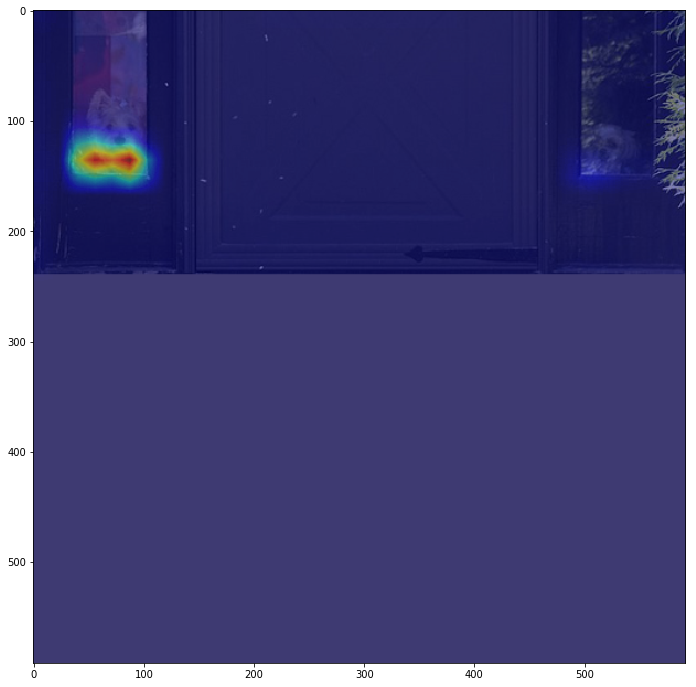

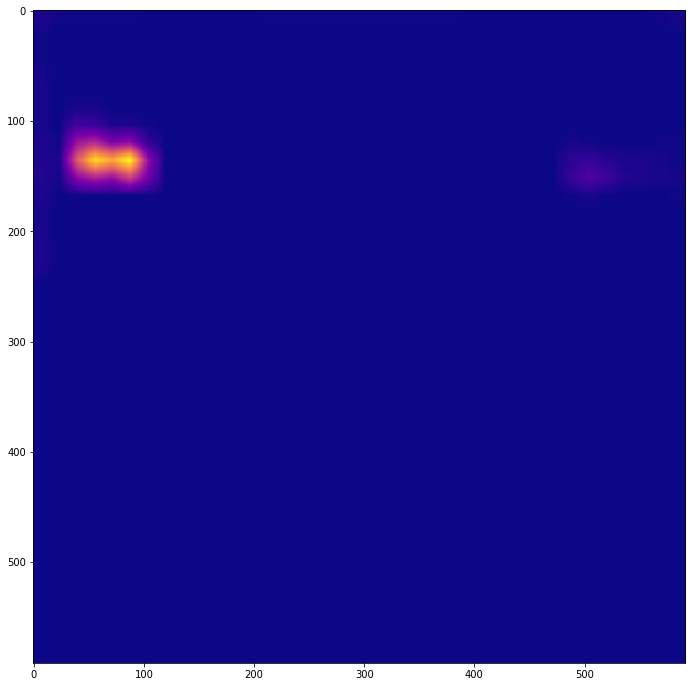

In [4]:
from PIL import Image
for b, batch in enumerate(train_loader):
    if b==0:
        #"""
        #print(transforms.ToPILImage()(batch[0][8].data[0][:, :15, :16]))
        #print(np.asarray(transforms.Resize(592)(transforms.ToPILImage()(batch[0][8].data[0])))[:592, :333])
        image = transforms.ToPILImage()(batch[0][0].data[0] * torch.FloatTensor([0.229, 0.224, 0.225])[:, None, None] 
                                        + torch.FloatTensor([0.485, 0.456, 0.406])[:, None, None]).convert('RGB')
        #image.show()
        saliency_map = transforms.Resize(592)(transforms.ToPILImage()(batch[0][8].data[0]))
        depth_map = transforms.ToPILImage()(batch[0][10].data[0])
        image = np.asarray(image)
        print(image)
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.imshow(image, aspect='equal')
        #saliency_map.show()
        #depth_map.show()
        depth_array = np.asarray(depth_map)
        sal_array = np.asarray(saliency_map)
        #print(depth_array)
        ax.imshow(sal_array, cmap='jet', alpha=0.5)
        #plt.imshow(saliency_map, cmap = cm.Greys_r)
        
        fig2, ax2 = plt.subplots(figsize=(12,12))
        ax2.imshow(sal_array, cmap='plasma')
        break

In [3]:
import pickle
with open('../vg200_kr_cap_gt4VC_allTestIM.pkl', 'rb') as f:
    vg200_kr_gt = pickle.load(f)
print(len(vg200_kr_gt))

8272


In [4]:
with open('../hrtree-predcls-relrank_stopgrad_mulsal_marginloss-vg200_kr', 'rb') as f:
    relrank_res = pickle.load(f)
with open('../../HRTree-Scene-Graph-Generation/hrtree-predcls-vg200_kr', 'rb') as f:
    norank_res = pickle.load(f)
print(len(norank_res))


8272


In [5]:
import json
with open('../checkpoints/captioning/hrtree-predcls-relrank_stopgrad_mulsal_marginloss-vg200_kr_caption_nr2_print_predictions.json') as f:
    caption_ranknr2 = json.load(f)
with open('../checkpoints/captioning/hrtree-predcls-vg200_kr_caption_nr2_print_predictions.json') as f:
    caption_noranknr2 = json.load(f)
print(len(caption_ranknr2))

8272


In [6]:
from lib.pytorch_misc import intersect_2d
from lib.fpn.box_intersections_cpu.bbox import bbox_overlaps
def _triplet(predicates, relations, classes, boxes,
             predicate_scores=None, class_scores=None):
    """
    format predictions into triplets
    :param predicates: A 1d numpy array of num_boxes*(num_boxes-1) predicates, corresponding to
                       each pair of possibilities
    :param relations: A (num_boxes*(num_boxes-1), 2) array, where each row represents the boxes
                      in that relation
    :param classes: A (num_boxes) array of the classes for each thing.
    :param boxes: A (num_boxes,4) array of the bounding boxes for everything.
    :param predicate_scores: A (num_boxes*(num_boxes-1)) array of the scores for each predicate
    :param class_scores: A (num_boxes) array of the likelihood for each object.
    :return: Triplets: (num_relations, 3) array of class, relation, class
             Triplet boxes: (num_relation, 8) array of boxes for the parts
             Triplet scores: num_relation array of the scores overall for the triplets
    """
    assert (predicates.shape[0] == relations.shape[0])

    sub_ob_classes = classes[relations[:, :2]]
    triplets = np.column_stack((sub_ob_classes[:, 0], predicates, sub_ob_classes[:, 1]))
    triplet_boxes = np.column_stack((boxes[relations[:, 0]], boxes[relations[:, 1]]))

    triplet_scores = None
    if predicate_scores is not None and class_scores is not None:
        triplet_scores = np.column_stack((
            class_scores[relations[:, 0]],
            class_scores[relations[:, 1]],
            predicate_scores,
        ))

    return triplets, triplet_boxes, triplet_scores

def _compute_pred_matches(gt_triplets, pred_triplets,
                 gt_boxes, pred_boxes, iou_thresh, phrdet=False):
    """
    Given a set of predicted triplets, return the list of matching GT's for each of the
    given predictions
    :param gt_triplets:
    :param pred_triplets:
    :param gt_boxes:
    :param pred_boxes:
    :param iou_thresh:
    :return:
    """
    # This performs a matrix multiplication-esque thing between the two arrays
    # Instead of summing, we want the equality, so we reduce in that way
    # The rows correspond to GT triplets, columns to pred triplets
    keeps = intersect_2d(gt_triplets, pred_triplets)
    gt_has_match = keeps.any(1)
    pred_to_gt = [[] for x in range(pred_boxes.shape[0])]
    for gt_ind, gt_box, keep_inds in zip(np.where(gt_has_match)[0],
                                         gt_boxes[gt_has_match],
                                         keeps[gt_has_match],
                                         ):
        boxes = pred_boxes[keep_inds]
        if phrdet:
            # Evaluate where the union box > 0.5
            gt_box_union = gt_box.reshape((2, 4))
            gt_box_union = np.concatenate((gt_box_union.min(0)[:2], gt_ox_union.max(0)[2:]), 0)

            box_union = boxes.reshape((-1, 2, 4))
            box_union = np.concatenate((box_union.min(1)[:,:2], box_union.max(1)[:,2:]), 1)

            inds = bbox_overlaps(gt_box_union[None], box_union)[0] >= iou_thresh

        else:
            sub_iou = bbox_overlaps(gt_box[None,:4], boxes[:, :4])[0]
            obj_iou = bbox_overlaps(gt_box[None,4:], boxes[:, 4:])[0]

            inds = (sub_iou >= iou_thresh) & (obj_iou >= iou_thresh)

        for i in np.where(keep_inds)[0][inds]:
            pred_to_gt[i].append(int(gt_ind))
    return pred_to_gt


def _compute_subobj_matches(gt_triplets, pred_triplets,
                 gt_boxes, pred_boxes, iou_thresh, phrdet=False):
    """
    Given a set of predicted triplets, return the list of matching GT's for each of the
    given predictions
    :param gt_triplets:
    :param pred_triplets:
    :param gt_boxes:
    :param pred_boxes:
    :param iou_thresh:
    :return:
    """
    # This performs a matrix multiplication-esque thing between the two arrays
    # Instead of summing, we want the equality, so we reduce in that way
    # The rows correspond to GT triplets, columns to pred triplets
    keeps = intersect_2d(np.column_stack((gt_triplets[:, 0:1], gt_triplets[:, 2:3])),
                         np.column_stack((pred_triplets[:, 0:1], pred_triplets[:, 2:3])))
    gt_has_match = keeps.any(1)
    pred_to_gt = [[] for x in range(pred_boxes.shape[0])]
    for gt_ind, gt_box, keep_inds in zip(np.where(gt_has_match)[0],
                                         gt_boxes[gt_has_match],
                                         keeps[gt_has_match],
                                         ):
        boxes = pred_boxes[keep_inds]
        if phrdet:
            # Evaluate where the union box > 0.5
            gt_box_union = gt_box.reshape((2, 4))
            gt_box_union = np.concatenate((gt_box_union.min(0)[:2], gt_box_union.max(0)[2:]), 0)

            box_union = boxes.reshape((-1, 2, 4))
            box_union = np.concatenate((box_union.min(1)[:,:2], box_union.max(1)[:,2:]), 1)

            inds = bbox_overlaps(gt_box_union[None], box_union)[0] >= iou_thresh

        else:
            sub_iou = bbox_overlaps(gt_box[None,:4], boxes[:, :4])[0]
            obj_iou = bbox_overlaps(gt_box[None,4:], boxes[:, 4:])[0]

            inds = (sub_iou >= iou_thresh) & (obj_iou >= iou_thresh)

        for i in np.where(keep_inds)[0][inds]:
            pred_to_gt[i].append(int(gt_ind))
    return pred_to_gt

In [7]:
def box_intersections(boxes, query_boxes):
    N = boxes.shape[0]
    K = query_boxes.shape[0]
    intersec = np.zeros((N, K))
    for k in range(K):
        box_area = (
            (query_boxes[k, 2] - query_boxes[k, 0] + 1) *
            (query_boxes[k, 3] - query_boxes[k, 1] + 1)
        )
        for n in range(N):
            iw = (
                min(boxes[n, 2], query_boxes[k, 2]) -
                max(boxes[n, 0], query_boxes[k, 0]) + 1
            )
            if iw > 0:
                ih = (
                    min(boxes[n, 3], query_boxes[k, 3]) -
                    max(boxes[n, 1], query_boxes[k, 1]) + 1
                )
                if ih > 0:
                    intersec[n, k] = iw * ih / box_area
    return np.transpose(intersec)

# generate scale-based entity tree, boxes include the virtual box and entity boxes
def gen_setree(boxes, labels, isc_thresh=0.9, pick_parent='area', ):
    areas = (boxes[:, 2] - boxes[:, 0] + 1) * (boxes[:, 3] - boxes[:, 1] + 1)
    sorted_id = np.argsort(-1 * areas)
    areas = areas[sorted_id]
    boxes = boxes[sorted_id]
    labels = [labels[i] for i in sorted_id]
    bbox_intersection = box_intersections(boxes, boxes)
    
    if pick_parent == 'isc':
        sort_key = 1
    elif pick_parent == 'area':
        sort_key = 2
        
    trees = [[] for _ in range(len(boxes))]
    for i in range(len(boxes)):
        if i == 0:
            continue
        current_box = boxes[i]
        possible_parent = []
        for j in range(1, i):
            M = bbox_intersection[i, j]
            N = bbox_intersection[j, i]
            if M > isc_thresh:
                possible_parent.append((j, N, areas[j]))
        if len(possible_parent) == 0:
            trees[0].append(i)
        else:
            parent_id = sorted(possible_parent, key=lambda d:d[sort_key], reverse=True)[0][0]
            trees[parent_id].append(i)
    return boxes, labels, trees
            

In [8]:
from functools import reduce
from graphviz import Digraph
from PIL import Image
from pdf2image import convert_from_path

def print_triplets(triplets, type='gt', num=100, gt_key_rels=None):
    for i, triple in enumerate(triplets[:num]):
        if gt_key_rels is not None and type=='gt' and i in gt_key_rels:
            prefix='**'
        else:
            prefix=''
        print(prefix+' '+ind_to_classes[triple[0]] + ' ' + ind_to_predicates[triple[1]] + ' ' + ind_to_classes[triple[2]])

def get_area_maps(shape, boxes):
    h, w = shape
    areas = (boxes[:, 2] - boxes[:, 0] + 1) * (boxes[:, 3] - boxes[:, 1] + 1)
    areas_ratios = areas / (h * w)
    #print(areas_ratios)
    num_boxes = boxes.shape[0]
    area_maps = np.ones([num_boxes, h, w], dtype=np.float) * 2

    for ind, box in enumerate(boxes):
        #print(box)
        box_int = box.astype(np.int)
        #print(box_int)
        area_maps[ind, box_int[1]:(box_int[3]+1), box_int[0]:(box_int[2]+1)] = areas_ratios[ind]

    area_maps = np.min(area_maps, axis=0)  # h,w
    empy, empx = np.where(area_maps == 2)
    if len(empy) > 0:
        area_maps[empy, empx] = 0
    return area_maps


def parse_gt(idx, gt_entry):
    if not os.path.isdir('./vg200KrTestGts'):
        os.makedirs('./vg200KrTestGts')
    # show the image
    image, sal_map, depth_map, captions = gt_entry['images'], gt_entry['sal_map'], gt_entry['depth_map'], gt_entry['captions']
    gt_rels = gt_entry['gt_relations']
    gt_boxes = gt_entry['gt_boxes'].astype(float)
    gt_boxes = gt_boxes / 1024. * 592.
    gt_classes = gt_entry['gt_classes']
    gt_key_rels = gt_entry['gt_key_rels'] if 'gt_key_rels' in gt_entry else None
    
    # show original image
    fig, ax = plt.subplots(figsize=(12, 12))
    image = np.asarray(image)
    ax.imshow(image, aspect='equal')
    ax.set_xticks([])
    ax.set_yticks([])
    
    # show and save saliency map
    sal_map = np.asarray(sal_map)
    sal_map = sal_map / 255.
    fig2, ax2= plt.subplots(figsize=(12, 12))
    ax2.imshow(image, aspect='equal')
    ax2.imshow(sal_map, cmap='jet', alpha=0.5)
    ax2.set_xticks([])
    ax2.set_yticks([])
    fig2.savefig('./vg200KrTestGts/%i_salmap.png'%idx, bbox_inches='tight', pad_inches=0.0)
    
    # show and save area map
    area_map = get_area_maps(image.shape[:2], gt_boxes)
    fig3, ax3= plt.subplots(figsize=(12, 12))
    ax3.imshow(image, aspect='equal')
    ax3.imshow(area_map, cmap='jet', alpha=0.5)
    ax3.set_xticks([])
    ax3.set_yticks([])
    fig3.savefig('./vg200KrTestGts/%i_areamap.png'%idx, bbox_inches='tight', pad_inches=0.0)
    
    # show and save mix map
    fig4, ax4= plt.subplots(figsize=(12, 12))
    ax4.imshow(image, aspect='equal')
    ax4.imshow(area_map+sal_map, cmap='jet', alpha=0.5)
    ax4.set_xticks([])
    ax4.set_yticks([])
    fig4.savefig('./vg200KrTestGts/%i_mixmap.png'%idx, bbox_inches='tight', pad_inches=0.0)
    
    # show and save the graph
    # show and save sg with bbox map, the entity has unique name. If they share the same category, use id to distinguish them. 
    u = Digraph('sg', filename='sg.gv')
    u.body.append('rankdir="LR"')
    u.node_attr.update(style='filled')
    gt_relinds = gt_rels[:, :2]
    gt_relinds_ravel = gt_rels[:, :2].ravel()
    viz_labels = gt_classes[gt_relinds_ravel]
    viz_rels = []
    for rel in gt_rels:
        if rel[0] in gt_relinds_ravel and rel[1] in gt_relinds_ravel:
            sub_idx = np.where(gt_relinds_ravel == rel[0])[0][0]
            obj_idx = np.where(gt_relinds_ravel == rel[1])[0][0]
            viz_rels.append([sub_idx, obj_idx, rel[2]])
    viz_rels = np.array(viz_rels)
    viz_relinds_ravel = viz_rels[:, :2].ravel().tolist()
    entity_name_list = []
    boxid_to_name = {}
    for i, l in enumerate(viz_labels):
        boxid = gt_relinds_ravel[i]
        if i in viz_relinds_ravel:
            base = ind_to_classes[l]
            name = ind_to_classes[l]+'_1'
            name_suffix = 2
            name_iter = name
            while name_iter in entity_name_list:
                name_iter = base + '_' + str(name_suffix)
                name_suffix += 1
            entity_name_list.append(name_iter)
            boxid_to_name[boxid] = name_iter
            u.node(str(i), label=name_iter, color='lightblue2')
    for rel in viz_rels:
        edge_key = '%s_%s' % (rel[0], rel[1])
        u.node(edge_key, label=ind_to_predicates[rel[2]], color='red')
        u.edge(str(rel[0]), edge_key)
        u.edge(edge_key, str(rel[1]))
    u.render('./vg200KrTestGts/%i_sg'%idx)
    fig5, ax5 = plt.subplots(figsize=(12, 12))
    sg_im = convert_from_path('./vg200KrTestGts/%i_sg.pdf'%idx)  # PIL list
    sg_im[0].save('./vg200KrTestGts/%i_sg.png'%idx)
    ax5.imshow(np.asarray(sg_im[0]), aspect='equal')
    ax5.set_xticks([])
    ax5.set_yticks([])
        
    # show the bbox image  and save.       
    fig6, ax6 = plt.subplots(figsize=(12, 12))
    ax6.imshow(image, aspect='equal')
    ax6.set_xticks([])
    ax6.set_yticks([])
    for i, box in enumerate(gt_boxes):
        if i not in boxid_to_name:
            edgecolor = 'red'
            base = ind_to_classes[gt_classes[i]]
            name = ind_to_classes[gt_classes[i]]+'_1'
            name_suffix = 2
            name_iter = name
            while name_iter in entity_name_list:
                name_iter = base + '_' + str(name_suffix)
                name_suffix += 1
            label_str = name_iter
            boxid_to_name[i] = name_iter
            entity_name_list.append(name_iter)
        else:
            edgecolor = 'red'
            label_str = boxid_to_name[i]
        ax6.add_patch(
            plt.Rectangle((box[0], box[1]),
                          box[2] - box[0],
                          box[3] - box[1], fill=False,
                          edgecolor=edgecolor, linewidth=3.5)
            )
        
        ax6.text(box[0], box[1] - 2,
                label_str,
                bbox=dict(facecolor='red', alpha=0.5),
                fontsize=14, color='white')
    fig6.savefig('./vg200KrTestGts/%i_bbox.png'%idx, bbox_inches='tight', pad_inches=0.0)
    
    # print the tree structure
    tree_boxes = gt_boxes.copy()
    h, w = image.shape[:2]
    tree_boxes = np.vstack((np.array([[0, 0, w-1, h-1]]), tree_boxes))
    boxid_to_name_list = [boxid_to_name[i] for i in range(len(gt_boxes))]
    boxid_to_name_list = ['__root__'] + boxid_to_name_list
    tree_boxes, tree_labels, trees = gen_setree(tree_boxes, boxid_to_name_list, pick_parent='isc')
    print('Trees!!!!!!!!!!!!!!!!!!')
    for p, t in enumerate(trees):
        children = [tree_labels[c] for c in t]
        print(tree_labels[p]+': '+', '.join(children))
    
    # show gt captions
    for sent in captions:
        print(' '.join(sent))
    
    # show gt triplets
    gt_triplets, gt_triplet_boxes, _ = _triplet(gt_rels[:, 2],
                                                gt_rels[:, :2],
                                                gt_classes,
                                                gt_boxes)
    print('gt relations:')
    print_triplets(gt_triplets, gt_key_rels=gt_key_rels)

    
def parse_entry(idx, gt_entry, pred_entry, mode='predcls', res='norank', num_show=5):
    #fig, ax = plt.subplots(figsize=(12, 12))
    #ax.imshow(gt_entry['images'], aspect='equal')
    image = gt_entry['images']
    image = np.asarray(image)
    
    gt_rels = gt_entry['gt_relations']
    gt_boxes = gt_entry['gt_boxes'].astype(float)
    gt_boxes = gt_boxes / 1024. * 592.
    gt_classes = gt_entry['gt_classes']
    gt_key_rels = gt_entry['gt_key_rels'] if 'gt_key_rels' in gt_entry else None

    pred_rel_inds = pred_entry['pred_rel_inds']
    rel_scores = pred_entry['rel_scores']
    rel_rank_scores = pred_entry['rel_rank_scores']
    if rel_rank_scores is not None:
        rel_scores *= rel_rank_scores[:, None]
    
    if mode == 'predcls':
        pred_boxes = gt_boxes
        pred_classes = gt_classes
        obj_scores = np.ones(gt_classes.shape[0])
    '''
    elif mode == 'sgcls':
        pred_boxes = gt_boxes
        pred_classes = pred_entry['pred_classes']
        obj_scores = pred_entry['obj_scores']
    elif mode == 'sgdet' or mode == 'phrdet':
        pred_boxes = pred_entry['pred_boxes'].astype(float)
        pred_classes = pred_entry['pred_classes']
        obj_scores = pred_entry['obj_scores']
    '''
    
    pred_rels = np.column_stack((pred_rel_inds, 1+rel_scores[:,1:].argmax(1)))
    predicate_scores = rel_scores[:,1:].max(1)
    
    gt_triplets, gt_triplet_boxes, _ = _triplet(gt_rels[:, 2],
                                                gt_rels[:, :2],
                                                gt_classes,
                                                gt_boxes)
    pred_triplets, pred_triplet_boxes, relation_scores = \
        _triplet(pred_rels[:,2], pred_rels[:,:2], pred_classes, pred_boxes,
                 rel_scores, obj_scores)
    
    print('predicted relations:')
    print_triplets(pred_triplets, type='pred', num=30)
    
    pred_to_gt = _compute_pred_matches(
        gt_triplets,
        pred_triplets,
        gt_triplet_boxes,
        pred_triplet_boxes,
        0.5,
        phrdet=False,
    )

    subobj_to_gt = _compute_subobj_matches(
        gt_triplets,
        pred_triplets,
        gt_triplet_boxes,
        pred_triplet_boxes,
        0.5,
        phrdet=False
    )
    
    match = reduce(np.union1d, pred_to_gt[:20]).astype(np.int32)
    key_match = np.intersect1d(match, gt_key_rels).astype(np.int32)
    
    proposal_match = reduce(np.union1d, subobj_to_gt[:20]).astype(np.int32)
    proposal_key_match = np.intersect1d(proposal_match, gt_key_rels).astype(np.int32)
    
    print('triplet match:')
    print_triplets(gt_triplets[match])
    print('key match:')
    print_triplets(gt_triplets[key_match])
    print('proposal match:')
    print_triplets(gt_triplets[proposal_match])
    print('proposal key match:')
    print_triplets(gt_triplets[proposal_key_match])
    
    # show and save the graph
    # show and save sg with bbox map, the entity has unique name. If they share the same category, use id to distinguish them. 
    u = Digraph('sg', filename='sg.gv')
    u.body.append('rankdir="LR"')
    u.node_attr.update(style='filled')
    show_pred_rels = pred_rels[:num_show, :]
    pred_relinds = show_pred_rels[:, :2]
    pred_relinds_ravel = show_pred_rels[:, :2].ravel()
    viz_labels = gt_classes[pred_relinds_ravel]
    viz_rels = []
    for rel in show_pred_rels:
        if rel[0] in pred_relinds_ravel and rel[1] in pred_relinds_ravel:
            sub_idx = np.where(pred_relinds_ravel == rel[0])[0][0]
            obj_idx = np.where(pred_relinds_ravel == rel[1])[0][0]
            viz_rels.append([sub_idx, obj_idx, rel[2]])
    viz_rels = np.array(viz_rels)
    viz_relinds_ravel = viz_rels[:, :2].ravel().tolist()
    entity_name_list = []
    boxid_to_name = {}
    for i, l in enumerate(viz_labels):
        boxid = pred_relinds_ravel[i]
        if i in viz_relinds_ravel:
            base = ind_to_classes[l]
            name = ind_to_classes[l]+'_1'
            name_suffix = 2
            name_iter = name
            while name_iter in entity_name_list:
                name_iter = base + '_' + str(name_suffix)
                name_suffix += 1
            entity_name_list.append(name_iter)
            boxid_to_name[boxid] = name_iter
            u.node(str(i), label=name_iter, color='lightblue2')
    for rel in viz_rels:
        edge_key = '%s_%s' % (rel[0], rel[1])
        u.node(edge_key, label=ind_to_predicates[rel[2]], color='red')
        u.edge(str(rel[0]), edge_key)
        u.edge(edge_key, str(rel[1]))
    u.render('./vg200KrTestGts/%i_sg_%s_pred%d'%(idx, res, num_show))
    fig, ax = plt.subplots(figsize=(12, 12))
    sg_im = convert_from_path('./vg200KrTestGts/%i_sg_%s_pred%d.pdf'%(idx, res, num_show))  # PIL list
    sg_im[0].save('./vg200KrTestGts/%i_sg_%s_pred%d.png'%(idx, res, num_show))
    ax.imshow(np.asarray(sg_im[0]), aspect='equal')
    ax.set_xticks([])
    ax.set_yticks([])
        
    # show the bbox image  and save.       
    fig2, ax2 = plt.subplots(figsize=(12, 12))
    ax2.imshow(image, aspect='equal')
    ax2.set_xticks([])
    ax2.set_yticks([])
    for i, box in enumerate(pred_boxes):
        if i not in boxid_to_name:
            edgecolor = 'green'
            base = ind_to_classes[gt_classes[i]]
            name = ind_to_classes[gt_classes[i]]+'_1'
            name_suffix = 2
            name_iter = name
            while name_iter in entity_name_list:
                name_iter = base + '_' + str(name_suffix)
                name_suffix += 1
            label_str = name_iter
            boxid_to_name[i] = name_iter
            entity_name_list.append(name_iter)
            continue
        else:
            edgecolor = 'red'
            label_str = boxid_to_name[i]
        ax2.add_patch(
            plt.Rectangle((box[0], box[1]),
                          box[2] - box[0],
                          box[3] - box[1], fill=False,
                          edgecolor=edgecolor, linewidth=3.5)
            )
        
        ax2.text(box[0], box[1] - 2,
                label_str,
                bbox=dict(facecolor='red', alpha=0.5),
                fontsize=14, color='white')
    fig2.savefig('./vg200KrTestGts/%i_bbox_%s_pred%d.png'%(idx, res, num_show), bbox_inches='tight', pad_inches=0.0)
    
    # print predicted caption
    print('ranking-nr2-caption: '+ caption_ranknr2[idx]['caption'])
    print('norank-nr2-caption: '+ caption_noranknr2[idx]['caption'])
    
    
    
    
    
    
    

Trees!!!!!!!!!!!!!!!!!!
__root__: couch_1, pillow_1, pillow_2
couch_1: dog_1, ball_1
dog_1: head_1, hair_1, tail_1, paw_2, paw_1
pillow_1: 
pillow_2: 
head_1: ear_1, mouth_1, ear_3
hair_1: 
ear_1: ear_2
ball_1: 
mouth_1: 
tail_1: 
paw_2: 
ear_3: 
paw_1: 
ear_2: 
a blue dog sitting on a striped couch
a dog that is sitting on a couch
a cool doggy sitting on the couch
a large brown dog sitting on top of a couch
a dog is sitting on a couch with a ball and two cushions in back
gt relations:
 ball above couch
 paw sitting on couch
 paw sitting on couch
 dog has tail
 dog has ear
 pillow on back of couch
 pillow on back of couch
** dog sitting on couch
 head of dog
 ear of dog
 ear of dog
 dog has mouth
 dog has tail
** dog on couch
** dog sitting on couch
** dog sitting on couch
** dog sitting on couch
 dog has head
 ball on couch
 ball on couch
 pillow on couch
 pillow on couch
predicted relations:
 dog has paw
 dog has paw
 dog has ear
 dog has ear
 dog has tail
 dog has ear
 dog has mouth

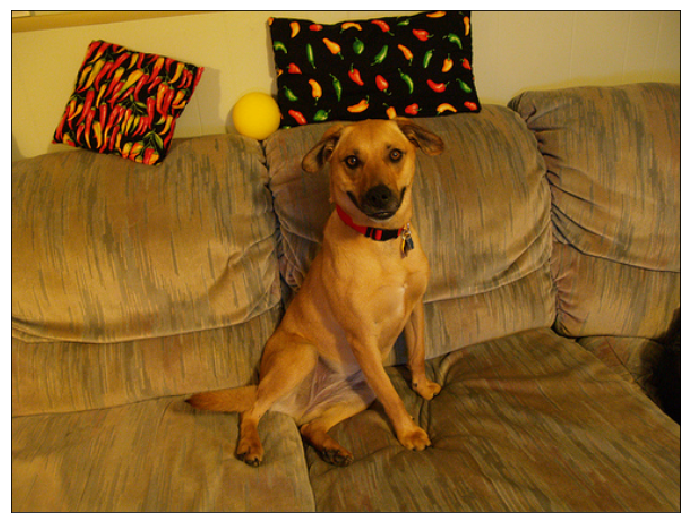

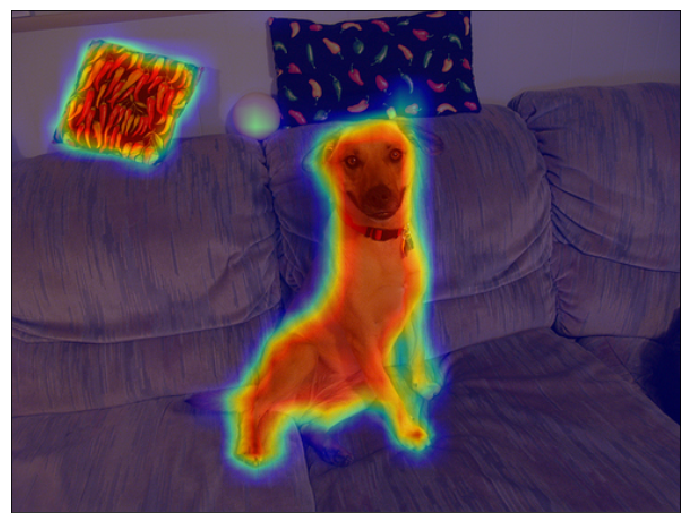

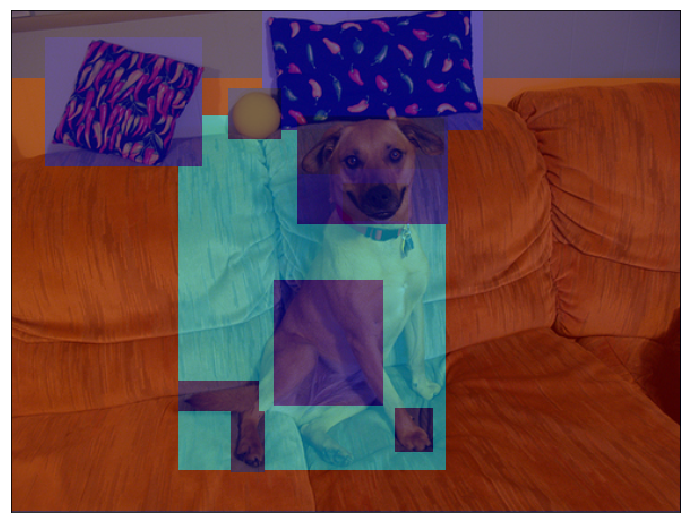

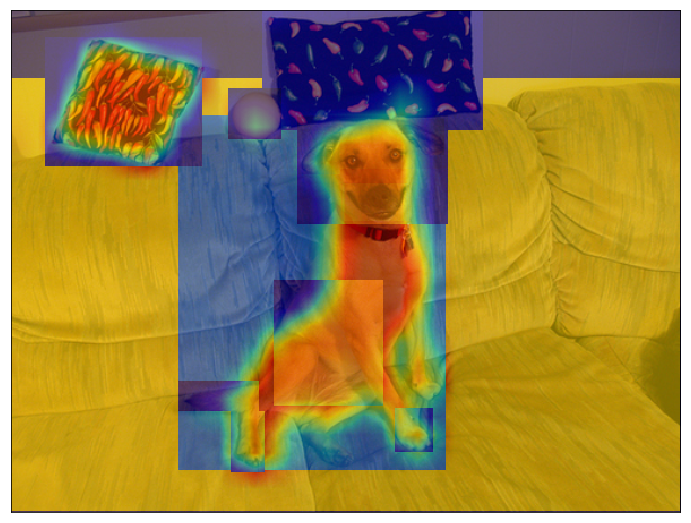

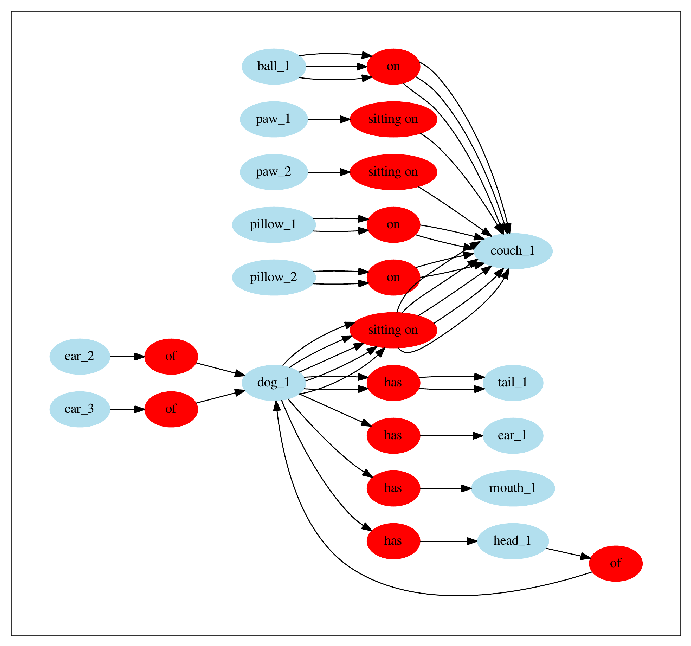

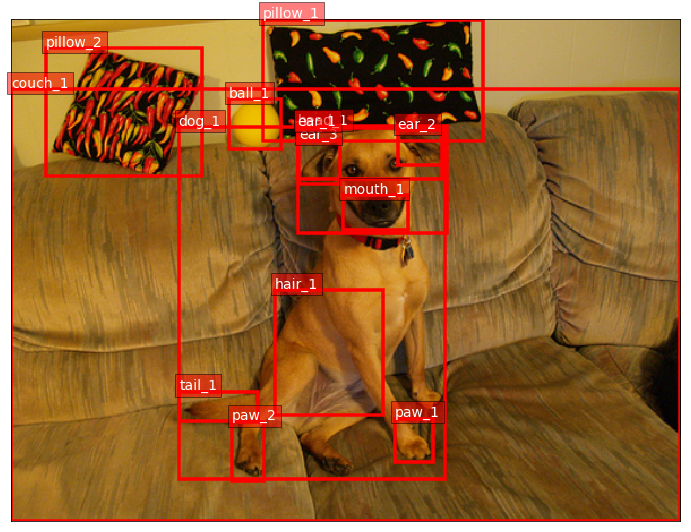

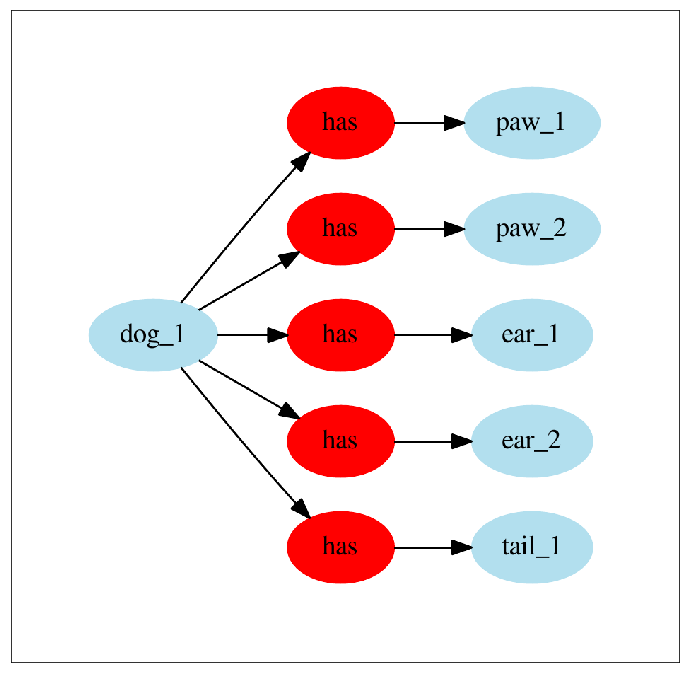

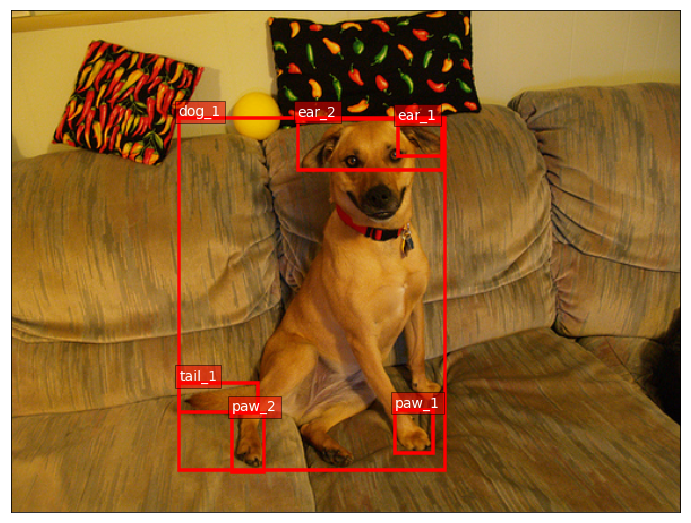

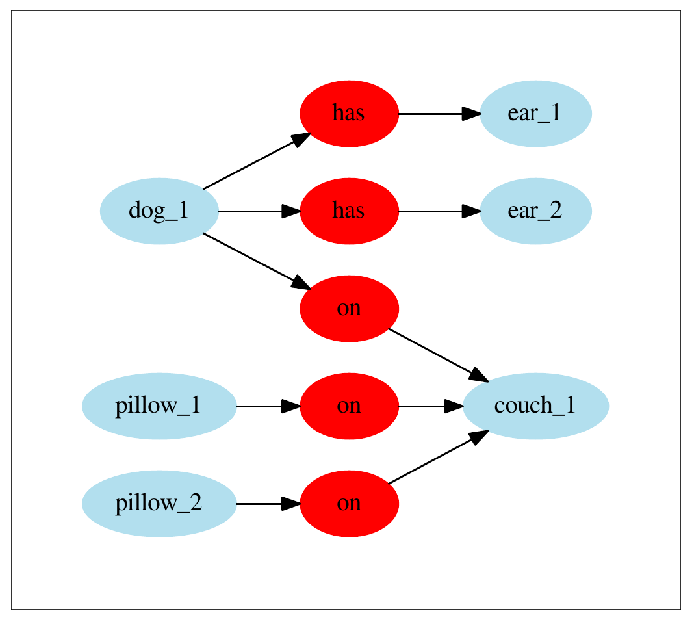

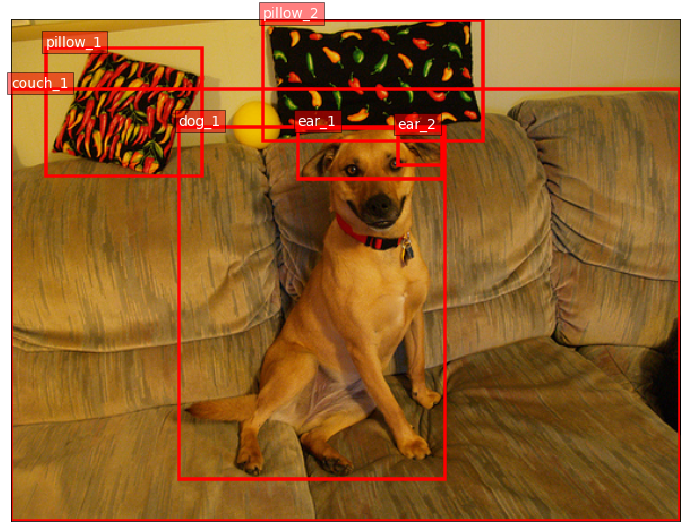

In [22]:
i=22
parse_gt(i, vg200_kr_gt[i])
#print(vg200_kr_gt[i])
parse_entry(i, vg200_kr_gt[i], norank_res[i], res='norank')
print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
parse_entry(i, vg200_kr_gt[i], relrank_res[i], res='rank')